In [393]:
import numpy as np
import scipy as sp
from scipy import io
from scipy import stats
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence



### **3. Wine Classification with Logistic Regression**

In [394]:
# set random state to replicate random paritioning of training and validation data 
rs = RandomState(MT19937(SeedSequence(694200)))


wine = io.loadmat("data_wine.mat")
# separate into training data, training labels, testing data, and feature descriptions
wine_raw_training_data = wine["X"] 
wine_training_labels = wine["y"]
wine_test_data = wine["X_test"]
wine_descriptions = wine["description"]

# attach labels to corresponding data, then shuffle
wine_tuples = np.hstack((wine_raw_training_data, wine_training_labels))
wine_tuples_shuffled = rs.permutation(wine_tuples)

# assign 500 tuples from randomly shuffled data to validation, the rest to training
wine_validation_data = wine_tuples_shuffled[0:500, 0:-1]
wine_validation_labels = wine_tuples_shuffled[0:500, -1]
wine_training_data = wine_tuples_shuffled[500:, 0:-1]
wine_training_labels = wine_tuples_shuffled[500:, -1]

# Standardize Data By Feature and Add Fictitious Dimension
training_features_means = np.mean(wine_training_data, axis=0)
training_features_sd = np.std(wine_training_data, axis=0)
wine_standardized_training_data = (wine_training_data - training_features_means) / training_features_sd
wine_training_data = np.hstack((wine_standardized_training_data, np.ones((wine_standardized_training_data.shape[0],1))))

# standardize validation and testing data by the training data's mean and std, add fictitious dimension to both as well
wine_validation_data = (wine_validation_data - training_features_means) / training_features_sd
wine_validation_data = np.hstack((wine_validation_data, np.ones((wine_validation_data.shape[0],1))))

wine_test_data = (wine_test_data - training_features_means) / training_features_sd
wine_test_data = np.hstack((wine_test_data, np.ones((wine_test_data.shape[0],1))))


In [395]:
def logistic_cost(data,labels,w):
    """
    Computes the logistic cost function

    :param data: the training data; for wine, expect (5500,13) matrix
    :param labels: the training labels; for wine, expect (5500,) vector
    :param w: the training weights; for wine, expect (13,) vector
    
    :return: scalar logistic cost
    """ 

    sigmoid = sp.special.expit(data@w) # s = 1 / (1 + e^(-Xw))

    first_component = -1 * np.dot(labels, np.log(sigmoid)) # -y . ln(s)
    second_component_sub_a = np.ones((data.shape[0], 1)).reshape(-1) - labels # 1-y
    second_component_sub_b = np.ones((data.shape[0], 1)).reshape(-1) - sigmoid #  1-s
    second_component = -1 * np.dot(second_component_sub_a, np.log(second_component_sub_b)) # -(1-y) . ln(1-s)
    
    # - y . ln(s) - (1-y) . ln(1-s)
    return first_component + second_component

In [396]:
def descend_bgd(alpha, data=wine_training_data, labels=wine_training_labels, ep = 0.0001, max_iters=10000, l2=0):
    """
    Operationalizes batch gradient descent in order to find the weights that best minimize the logistic cost function

    :param alpha: the learning rate (hyperparameter)
    :param data: the training data
    :param labels: the training labels
    :param ep: desired difference in current and previous cost, indicator of convergence
    :param max_iters: maximum number of interactions (batches)
    :param l2: regularization parameter in L2

    :return: most recent gradient vector, weights vector, logistic cost
    """

    converged = False
    w_i = rs.random((13,))
    iter = 0
    J = logistic_cost(data,labels, w_i)
    
    while not converged:
        # compute the gradient
        residual = sp.special.expit(data @ w_i) - labels
        gradient = (data.T @ (residual)) + (2 * l2 * w_i)

        # update the weights
        w_i = w_i - alpha * gradient

        # find new cost
        e = logistic_cost(data,labels, w_i)
        if abs(J-e) <= ep:
            print(f"Converged, iterations: {iter}")
            converged =  True
        
        J = e # update error
        iter += 1

        if iter == max_iters:
            print(f"Max iteractions {max_iters} exceeded")
            converged = True
        
    return gradient, w_i, J


Max iteractions 100 exceeded
Max iteractions 250 exceeded
Max iteractions 500 exceeded
Max iteractions 1000 exceeded
Max iteractions 2500 exceeded
Converged, iterations: 3736
Converged, iterations: 3736
Converged, iterations: 3749


Text(0, 0.5, 'Value of the Cost Function')

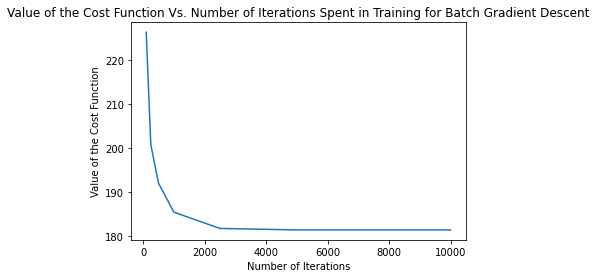

In [397]:
rs = RandomState(MT19937(SeedSequence(42069)))

num_iters = [100,250,500,1000,2500,5000,7500,10000]
cost_function_values = [descend_bgd(0.0005, wine_training_data, wine_training_labels, max_iters=i)[2] for i in num_iters]
plt.plot(num_iters, cost_function_values)
plt.title("Value of the Cost Function Vs. Number of Iterations Spent in Training for Batch Gradient Descent")
plt.xlabel("Number of Iterations")
plt.ylabel("Value of the Cost Function")

In [398]:
def descend_sgd(alpha, data=wine_training_data, labels=wine_training_labels, ep = 0.0001, max_iters=10000, l2=4):
    """
    Operationalizes stochastic gradient descent in order to find the weights that best minimize the logistic cost function

    :param alpha: the learning rate (hyperparameter)
    :param data: the training data
    :param labels: the training labels
    :param ep: desired difference in current and previous cost, indicator of convergence
    :param max_iters: maximum number of interactions (batches)
    :param l2: regularization parameter in L2

    :return: most recent gradient vector, weights vector, logistic cost
    """
    
    converged = False
    w_i = rs.random((13,))
    iter = 0
    J = logistic_cost(data,labels, w_i)
    
    while not converged:
        # compute the gradient
        random_int = rs.randint(0, data.shape[0])
        sample = data[random_int][:].reshape((1,13))
        residual = sp.special.expit(sample @ w_i) - labels[random_int]
        gradient = (sample.T @ residual) + (2 * l2 * w_i)

        # update the weights
        w_i = w_i - alpha * gradient

        # find new cost
        e = logistic_cost(data,labels, w_i)
        if abs(J-e) <= ep:
            print(f"Converged, iterations: {iter}")
            converged =  True
        
        J = e # update error
        iter += 1

        if iter == max_iters:
            print(f"Max iteractions {max_iters} exceeded")
            converged = True
        
    return gradient, w_i, J

Max iteractions 100 exceeded
Max iteractions 250 exceeded
Max iteractions 500 exceeded
Max iteractions 1000 exceeded
Max iteractions 2500 exceeded
Converged, iterations: 3907
Converged, iterations: 7172
Converged, iterations: 2516


Text(0, 0.5, 'Value of the Cost Function')

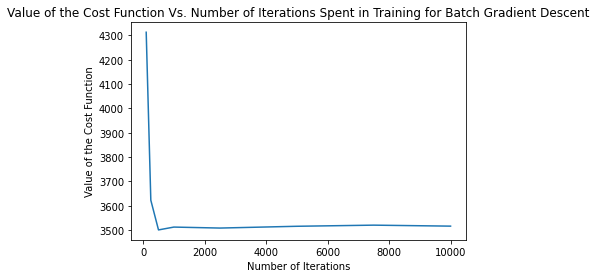

In [399]:
rs = RandomState(MT19937(SeedSequence(42069420)))

num_iters = [100,250,500,1000,2500,5000,7500,10000]
cost_function_values = [descend_sgd(0.0005, wine_training_data, wine_training_labels, max_iters=i, l2=4)[2] for i in num_iters]
plt.plot(num_iters, cost_function_values)
plt.title("Value of the Cost Function Vs. Number of Iterations Spent in Training for Batch Gradient Descent")
plt.xlabel("Number of Iterations")
plt.ylabel("Value of the Cost Function")

In [416]:
test_predictions = np.round(sp.special.expit(wine_test_data @ bgd[1]))

wine_pd = pd.DataFrame(np.int64(test_predictions),columns=['Category'])
wine_pd.index.name = 'Id'
wine_pd.index += 1
wine_pd.to_csv("wine_test_predictions.csv")